## Guess the Genre!
k-nn Classification on Spotify songs based on their numerical statistics.

## Introduction

provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report</br>
clearly state the question you tried to answer with your project</br>
identify and describe the dataset that was used to answer the question</br>

### Methods & Results

In [ ]:
install.packages("corrplot")

In [ ]:
### Loading Libraries into R
### Run this cell before continuing.
library(tidymodels)
library(tidyverse)
library(repr)
library(cowplot)
library(GGally)
library(caret)
library(stats)
library(corrplot)
options(repr.matrix.max.rows = 6)

**1. Loading the Data** </br>
The data, originally sourced from Kaggle, is loaded in from an online source.

In [82]:
set.seed(200)
raw_data <- read_csv("https://raw.githubusercontent.com/Lollipop-27/DCSI100-Project/main/data/music_genre.csv")

Parsed with column specification:
cols(
  instance_id = col_double(),
  artist_name = col_character(),
  track_name = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_character(),
  obtained_date = col_character(),
  valence = col_double(),
  music_genre = col_character()
)



**2. Wrangling & Cleaning the Data** </br>
The data has a few rows with missing N/A values. We remove them using na.omit(). The raw data set we selected has about 50,000 rows, whose excessive size is a serious limitation on performance and causes minute-long load times. For sake of reasonable computation time and after discussion with the teaching assistant, we chose use group_by() and sample_n() to randomly select 1000 rows from each of the 10 genres, for a total of 10,000 rows.

In [84]:
set.seed(1234)

data <- raw_data #%>%
            group_by(music_genre) %>%
            slice_sample(n=1000)
data

instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,04-Apr,0.759,Electronic
46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,04-Apr,0.531,Electronic
30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,04-Apr,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39767,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,D,0.143,-5.443,Major,0.1460,131.079,04-Apr,0.395,Hip-Hop
57944,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,G,0.106,-5.016,Minor,0.0441,75.886,04-Apr,0.354,Hip-Hop
63470,Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,F#,0.272,-13.652,Minor,0.1010,99.201,04-Apr,0.765,Hip-Hop


Some columns are unusable for predicting genre because kknn classification requires numerical predictors. We used select() to remove all character columns excluding the music_genre column, which we used mutate() to turn into factors.

A usable column with numerical values, tempo, is incorrectly stored as a character column. We use mutate() to turn it into a double. 

Obtained dates was formatted in a strange way so we used mutate() to change it to yyyy-mm-dd format.

In [85]:
#cleaning the vectors type and n/a genres
data <- data%>%
  mutate (music_genre = as_factor(music_genre)) %>%
  filter(!is.na(music_genre)) %>%
  filter(tempo != "?") %>%
  mutate(tempo = as.double(tempo)) %>%
  mutate(key = as_factor(key)) %>%
  mutate(mode = as_factor (mode)) 

#cleaning the date column
data <- mutate(data,
              obtained_date = 
                as.Date(paste(data$obtained_date, "-21",sep = ""), 
                        "%d-%b-%y")) %>%
    group_by(music_genre) %>%
    slice_sample(n=1000) %>%
    ungroup()
data

instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<fct>
61075,Great Dane,Stormy Weather,38,0.021900,0.477,173913,0.722,0.000529,G,0.1120,-7.669,Major,0.2400,85.739,2021-04-04,0.257,Electronic
43796,Seven Lions,The Truth,33,0.000857,0.755,332908,0.488,0.721000,C,0.0863,-7.725,Major,0.2580,127.991,2021-04-04,0.368,Electronic
35837,Slushii,Out of Light,43,0.063000,0.598,202860,0.786,0.000166,B,0.2020,-5.604,Major,0.0546,89.977,2021-04-04,0.381,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
23715,Kota the Friend,Daylight,51,0.6420,0.553,177237,0.491,0e+00,A,0.0733,-7.467,Major,0.3880,79.000,2021-04-04,0.7620,Hip-Hop
82091,Jidenna,Classic Man - Remix,54,0.1190,0.851,235046,0.657,0e+00,D,0.0743,-5.161,Major,0.0559,94.036,2021-04-04,0.6440,Hip-Hop
61725,$uicideBoy$,Do You Believe In God?,65,0.0388,0.794,118073,0.534,1e-05,C,0.5550,-5.698,Major,0.0509,120.069,2021-04-04,0.0487,Hip-Hop


**3. Exploratory Analysis** 

We wanted to have a more clear display of which predictors which should use. First we took the mean of each variable for each genre. We then made a plot on the different audio features on the music genres.

`summarise()` ungrouping output (override with `.groups` argument)



Rows: 10
Columns: 12
$ music_genre          <fct> Electronic, Anime, Jazz, Alternative, Country, R…
$ avg_popularity       <dbl> 38.466, 23.901, 40.990, 50.232, 46.049, 60.565, …
$ avg_acousticness     <dbl> 0.1071572, 0.2771263, 0.4847415, 0.1617832, 0.27…
$ avg_danceability     <dbl> 0.6283250, 0.4753742, 0.5959144, 0.5405810, 0.57…
$ avg_duration_ms      <dbl> 249413.5, 210310.9, 236928.3, 208904.3, 198980.9…
$ avg_energy           <dbl> 0.7433300, 0.6704206, 0.4800879, 0.7061344, 0.63…
$ avg_instrumentalness <dbl> 0.357243236, 0.275841266, 0.349396789, 0.0607278…
$ avg_liveness         <dbl> 0.2141856, 0.1909323, 0.1729273, 0.1950151, 0.18…
$ avg_loudness         <dbl> -7.045728, -7.894089, -10.998532, -6.586071, -7.…
$ avg_speechiness      <dbl> 0.1039737, 0.0631987, 0.0742226, 0.0913587, 0.04…
$ avg_tempo            <dbl> 126.2642, 128.9037, 111.9532, 122.2892, 123.8504…
$ avg_valence          <dbl> 0.3865391, 0.4392651, 0.5232395, 0.4454982, 0.53…


music_genre,avg_popularity,avg_acousticness,avg_danceability,avg_duration_ms,avg_energy,avg_instrumentalness,avg_liveness,avg_loudness,avg_speechiness,avg_tempo,avg_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Electronic,38.466,0.1071572,0.6283250,249413.5,0.7433300,0.3572432,0.2141856,-7.045728,0.1039737,126.2642,0.3865391
Anime,23.901,0.2771263,0.4753742,210310.9,0.6704206,0.2758413,0.1909323,-7.894089,0.0631987,128.9037,0.4392651
Jazz,40.990,0.4847415,0.5959144,236928.3,0.4800879,0.3493968,0.1729273,-10.998532,0.0742226,111.9532,0.5232395
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Rock,59.698,0.1932662,0.5391120,211910.2,0.6832212,0.05159139,0.1867937,-7.296232,0.0536170,120.9796,0.5213411
Classical,30.164,0.8563031,0.3066129,275623.8,0.1857480,0.58362886,0.1686202,-21.333040,0.0523803,105.3889,0.2121512
Hip-Hop,58.119,0.1792034,0.7169650,198937.8,0.6501050,0.01017748,0.1989017,-6.885099,0.2059331,119.6674,0.4824495


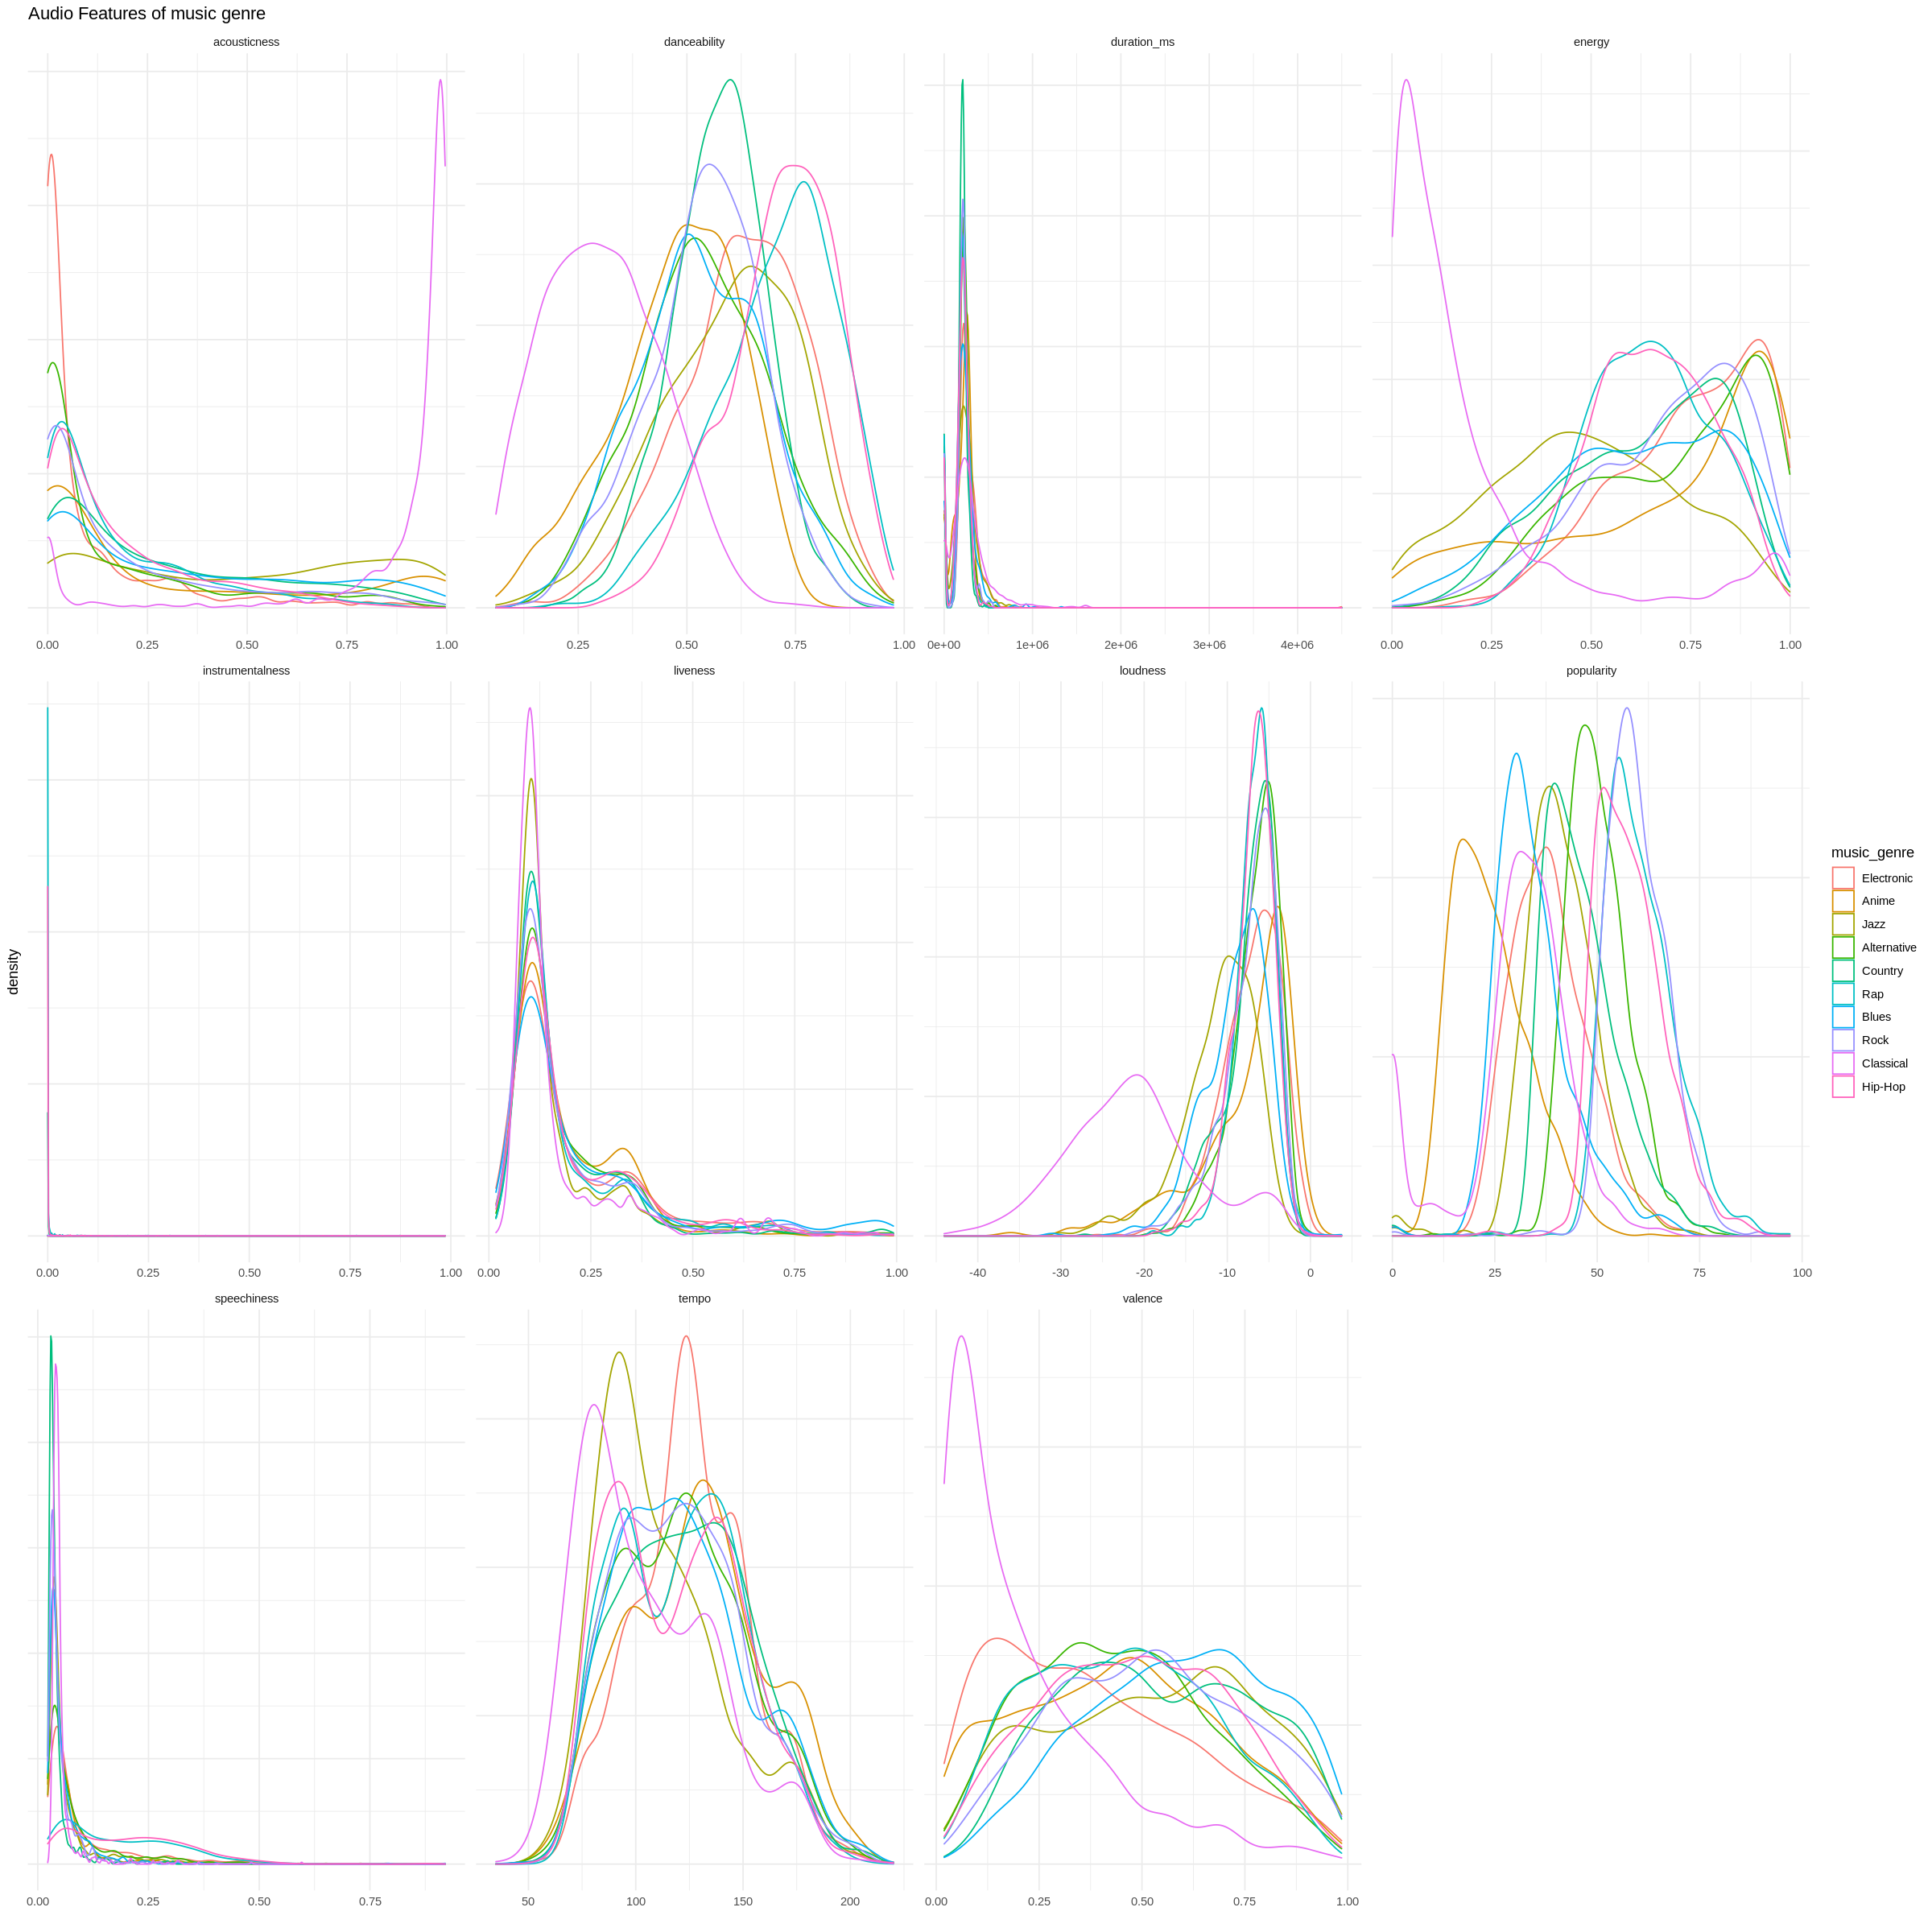

In [86]:
#dataframe of mean of each variable for each genre
general_distribution <- data %>%
  group_by(music_genre) %>%
  summarise(avg_popularity = mean(popularity),
            avg_acousticness = mean(acousticness),
            avg_danceability = mean(danceability),
            avg_duration_ms = mean(duration_ms),
            avg_energy = mean(energy),
            avg_instrumentalness = mean(instrumentalness),
            avg_liveness = mean(liveness),
            avg_loudness = mean(loudness),
            avg_speechiness = mean(speechiness),
            avg_tempo = mean(tempo),
            avg_valence = mean(valence)) %>%
  glimpse()

general_distribution
data %>% 
  select(music_genre, instrumentalness, acousticness,danceability,energy,
         popularity, loudness,duration_ms, liveness, speechiness, tempo, valence) %>% 
  pivot_longer(2:12) %>% 
  ggplot(aes(x = value)) + 
  geom_density(aes(color = music_genre)) +
  facet_wrap(~name, ncol =4, scales="free") +
  labs(title = "Audio Features of music genre", x = "", y = "density")+      
  theme_minimal() + theme(axis.text.y = element_blank())

@Negin 

Adding missing grouping variables: `music_genre`



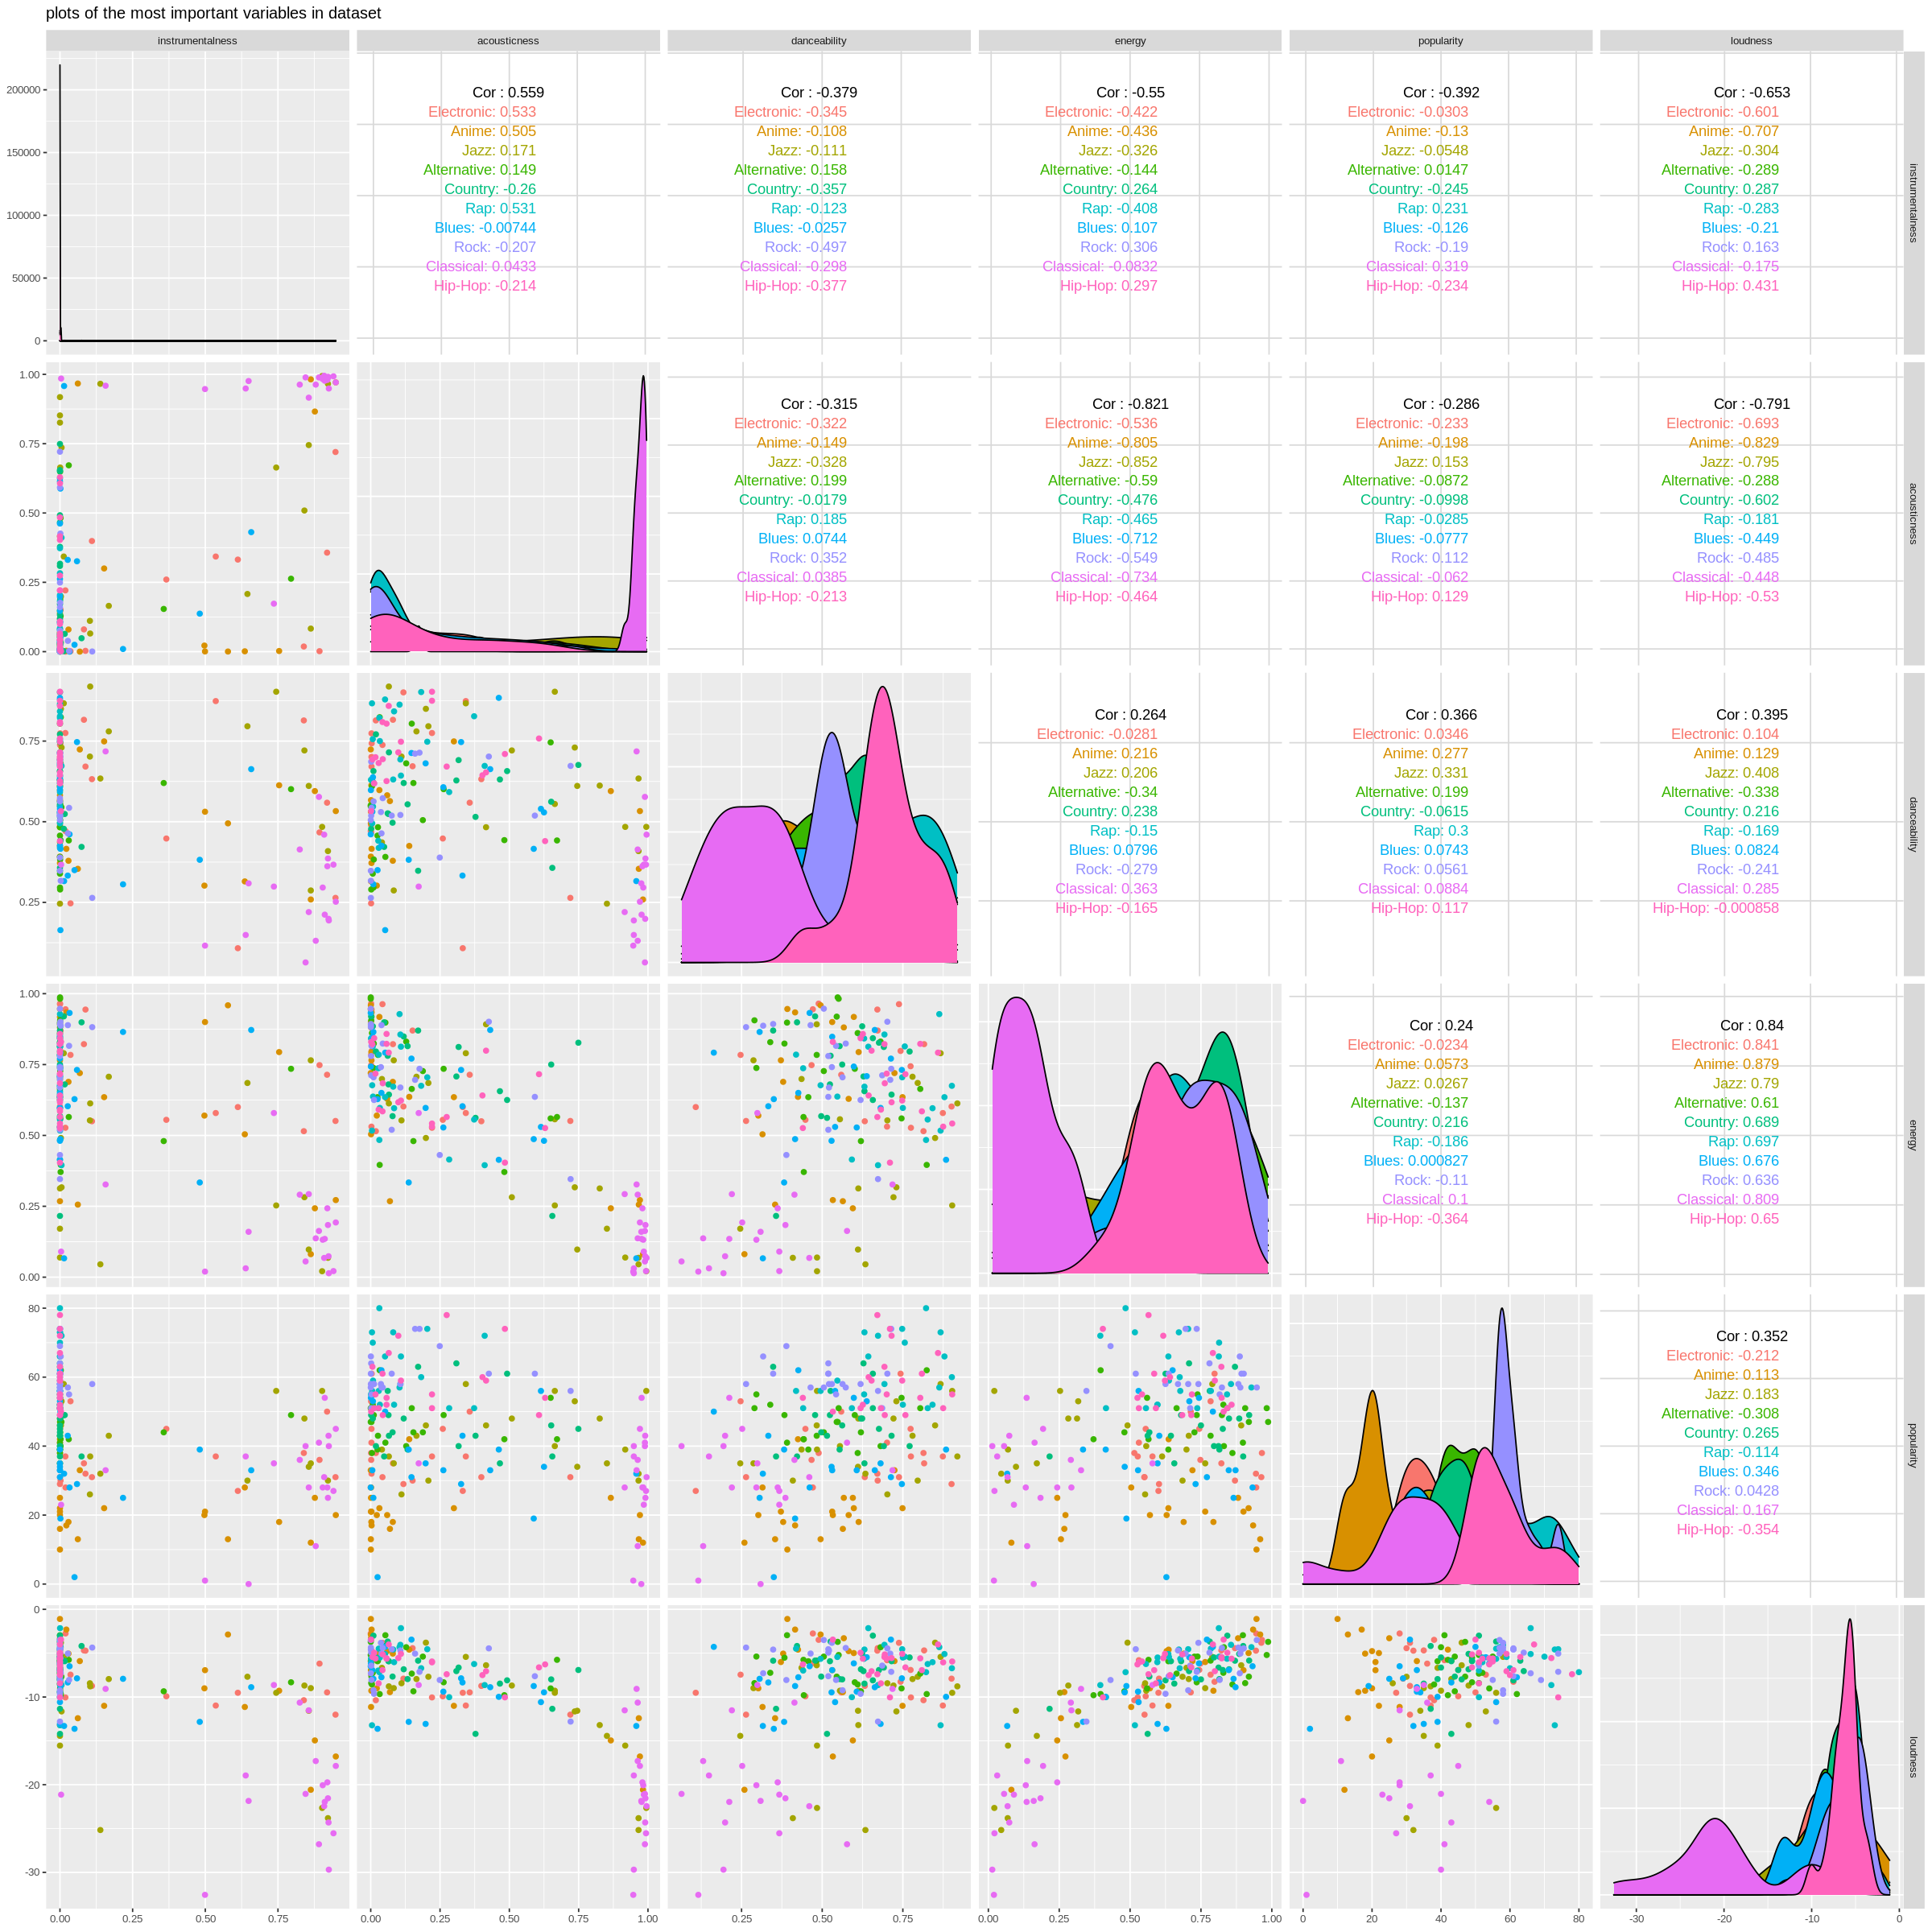

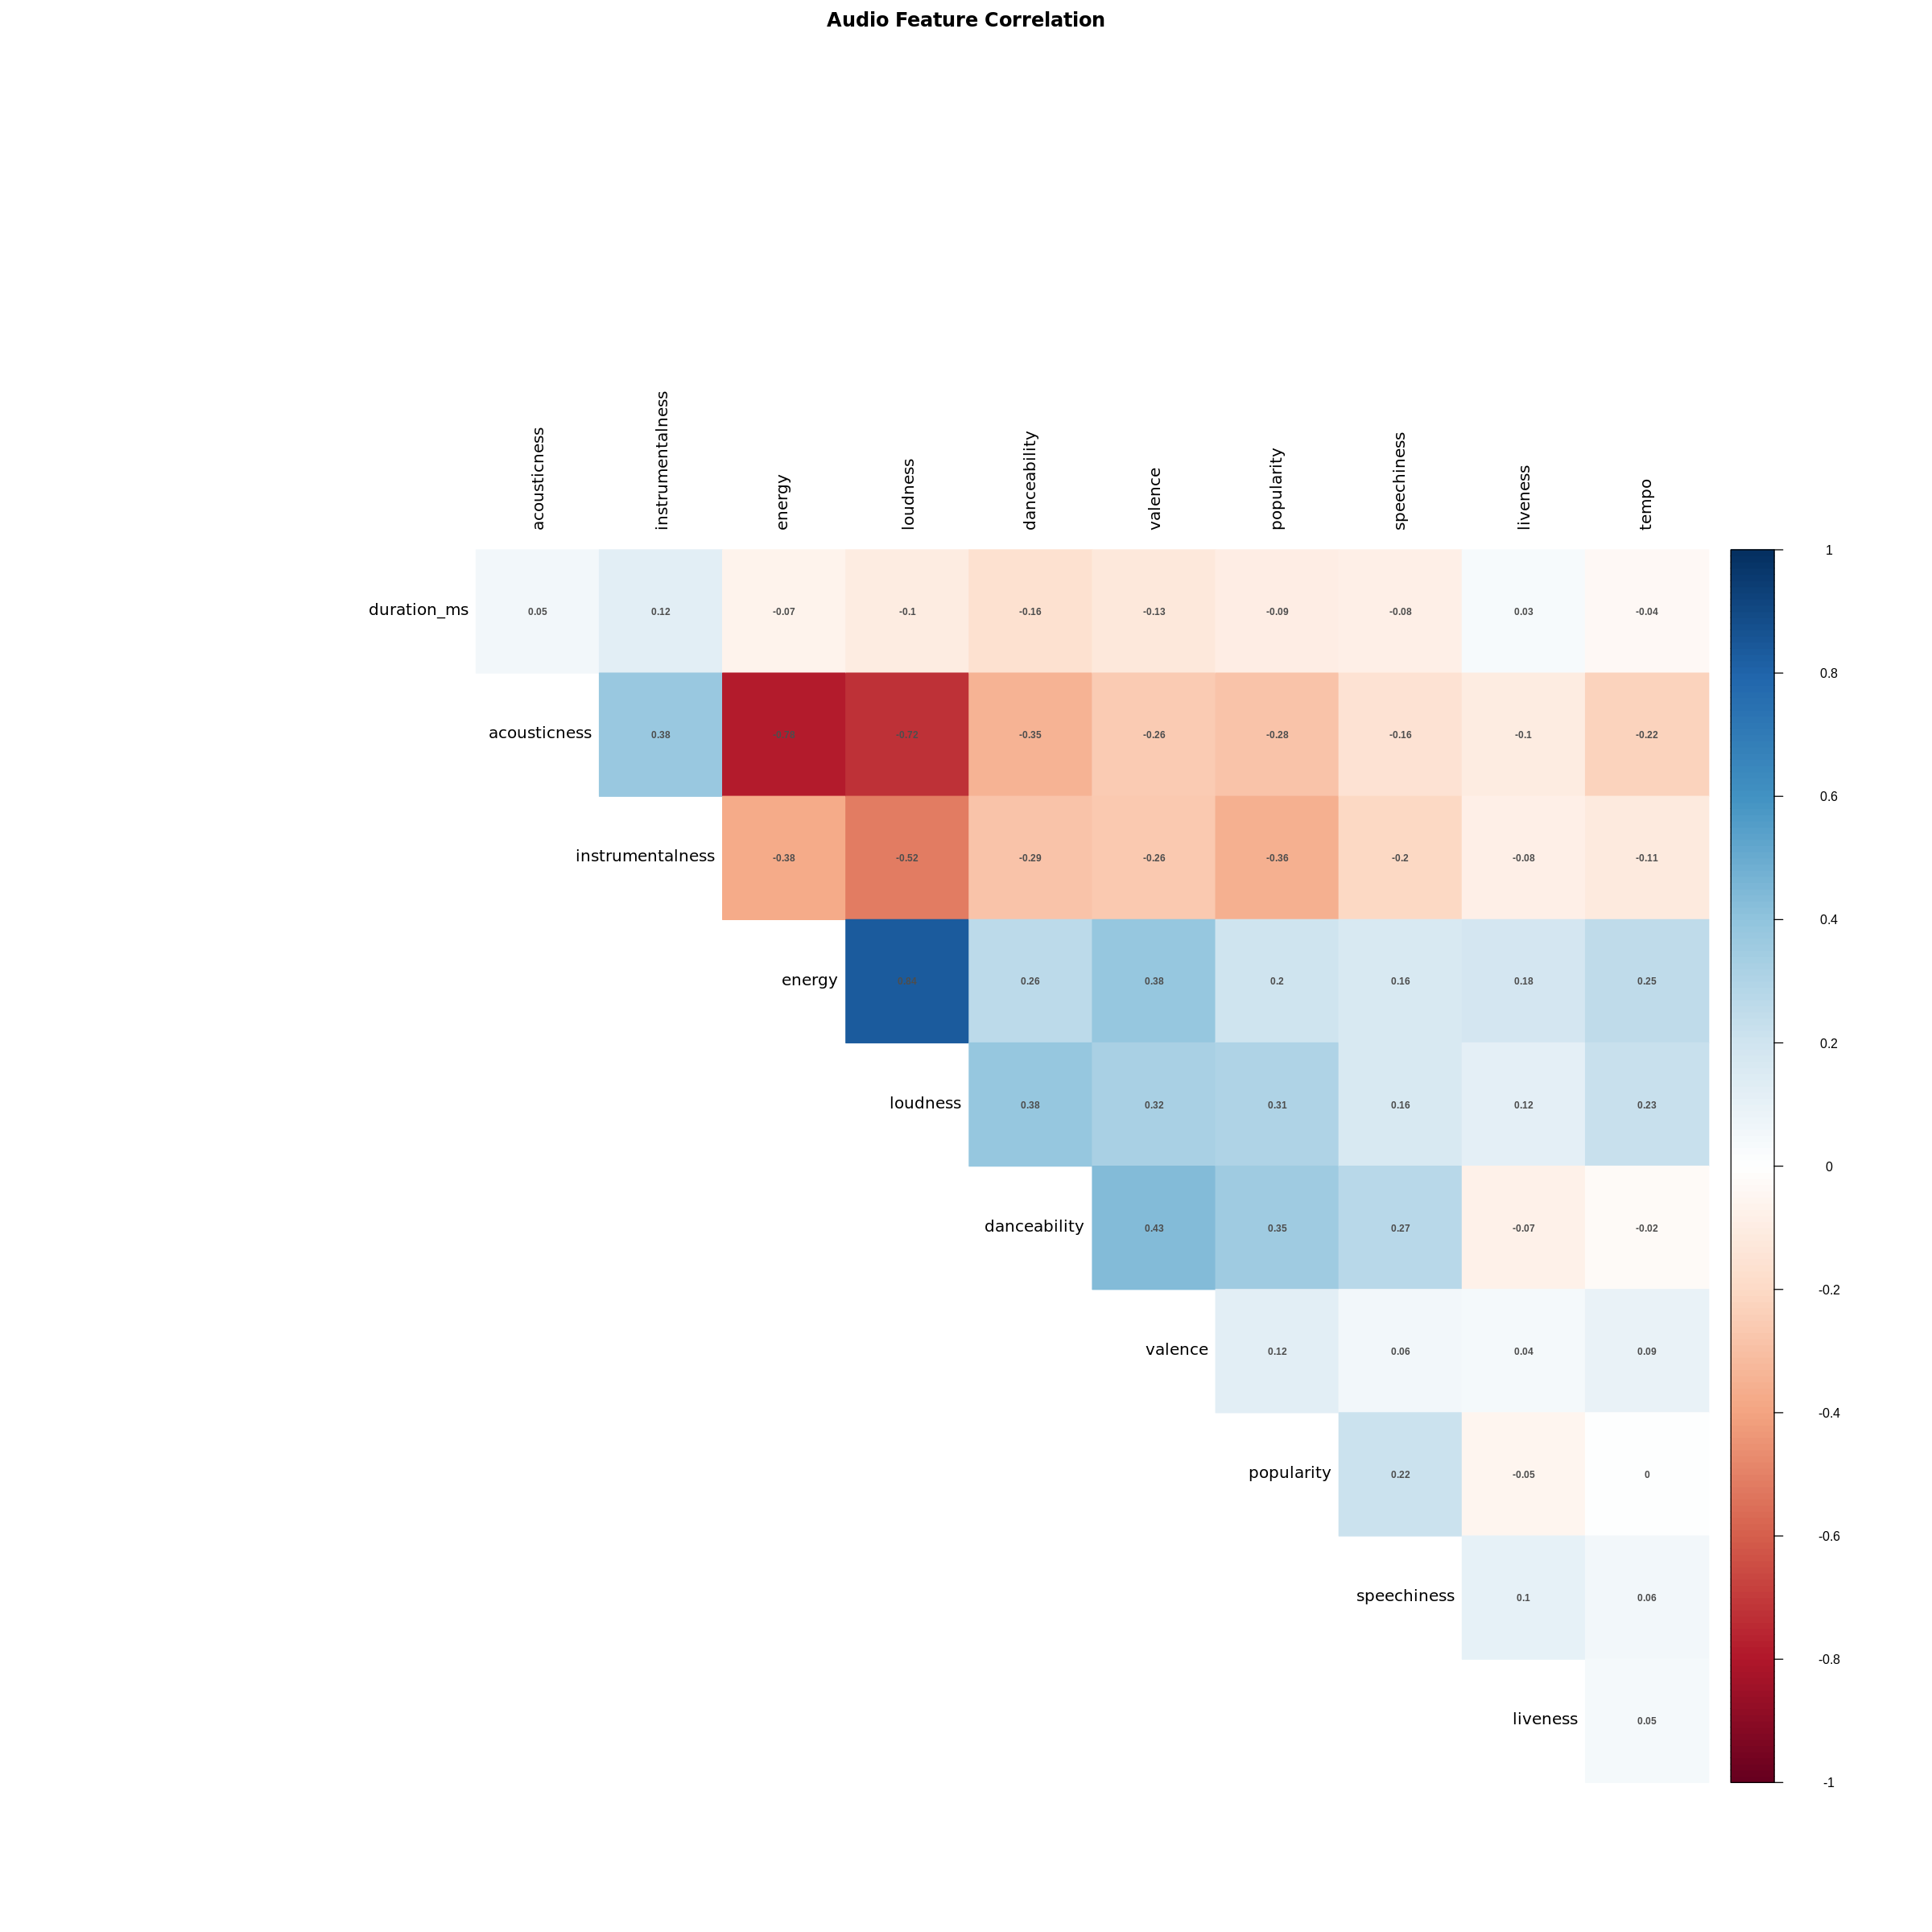

In [87]:
#finding the most important variables to distinguish music genre
rrfMod <- train(music_genre ~ popularity+acousticness + danceability + duration_ms+
                  energy + instrumentalness + liveness + loudness +
                  speechiness +tempo +valence , data=data, method="rpart")
rrfImp <- varImp(rrfMod)

#use a sample of n=20 from each group to plot
samples <- data %>%
  group_by(music_genre) %>%
  slice_sample(n=20) %>%
  select(instrumentalness, acousticness,danceability,energy,popularity, loudness)
#plots of each 2 variables from rrfImp
options(repr.plot.height = 20, repr.plot.width = 20)
variables_plot <- ggpairs(samples, columns = 2:7, ggplot2::aes(colour = music_genre)) +
  ggtitle("plots of the most important variables in dataset") +
  theme(text = element_text(size =10))
variables_plot
#So we should remove one of energy or loudness, based on density, we remove loudness
data %>%
  select(popularity,acousticness ,danceability , duration_ms,
           energy , instrumentalness , liveness , loudness ,
           speechiness ,tempo ,valence) %>%
  scale() %>%
  cor() %>%
  corrplot::corrplot(method = 'color', 
                     order = 'hclust', 
                     type = 'upper', 
                     diag = FALSE, 
                     tl.col = 'black',
                     addCoef.col = "grey30",
                     number.cex = 0.6,
                     
                     main = 'Audio Feature Correlation',
                     mar = c(2,2,2,2),
                     family = 'Avenir')

We now split the data into our training and testing sets.

In [81]:
data_split <- initial_split(data, prop = 0.75, strata = music_genre)
 data_training <- training(data_split)
 data_testing <- testing(data_split)

We chose to split at 75: 25 because we all agreed that it would be a split, which will tell us whether our model was over-fitted or under-fitted. We will have the appropriate amount of data for training and testing.

**4. Data Analysis** </br>
For the data recipe, we choose to use popularity, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, and valence as our predictors to predict the music genre.

We perform five-fold cross validation on our data with the data_recipe and data_spec we created earlier and try 20 different k values. We used collect_metrics() to aggregate the mean and standard error for each k value, and plot it on a line plot to visualize the accuracies and identify the best neighbour count.

In [94]:
# Set the seed
set.seed(1234) 

# Create the model
genre_recipe <- recipe(music_genre ~ popularity + danceability + acousticness +
                        energy +
                       tempo + valence,
                      data = data_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

genre_vfold <- vfold_cv(data_train, v = 5, strata = music_genre)

genre_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100))

genre_results <- workflow() %>%
      add_recipe(genre_recipe) %>%
      add_model(genre_tune) %>%
      tune_grid(resamples = genre_vfold, grid = 20) %>%
      collect_metrics()

accuracies <- genre_results %>%
      filter(.metric == "accuracy")

# Display the k value accuracies
options(repr.plot.height = 5, repr.plot.width = 6)

cross_val_plot <- ggplot(knn_results, aes(x= neighbors, y = mean)) + geom_point()

cross_val_plot

x Fold1: recipe: Error: All columns selected for the step should be numeric

x Fold2: recipe: Error: All columns selected for the step should be numeric

x Fold3: recipe: Error: All columns selected for the step should be numeric

x Fold4: recipe: Error: All columns selected for the step should be numeric

x Fold5: recipe: Error: All columns selected for the step should be numeric

Warning message:
“All models failed in tune_grid(). See the `.notes` column.”


ERROR: Error: All of the models failed. See the .notes column.


Accuracy is highest at k=14, so we recreate our workflow using k=14.

In [ ]:
# Set the seed. 
set.seed(9999) 

# Build model with k=14
genre_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
       set_engine("kknn") %>%
       set_mode("classification")

genre_fit <- workflow() %>%
       add_recipe(data_recipe) %>%
       add_model(genre_spec) %>%
       fit(data = data_train)

We used our final model to make predictions on the test data set, and used the bind_cols function to join the prediction column to the original test data. We then report the accuracy of this prediction using the metrics function. We also report the confusion matrix using the conf_mat function.

In [ ]:
data_predictions <- predict(genre_fit , data_test) %>%
      bind_cols(data_test)

data_metrics <- data_predictions %>%
       metrics(truth = music_genre, estimate = .pred_class)

data_conf_mat<- data_predictions %>%
       conf_mat(truth = music_genre, estimate = .pred_class)

data_metrics
data_conf_mat

It seems Anime, Blues, Classical, Country, and Rock are predicted with good accuracy, but Alternative, Electronic, Hip-Hop, Jazz and Rap are easily confused with one or a few other genres (Understandably, hip-hop and rap, for example, are very similar genres and have a lot of overlap).

**5. Let's Try it Out!** </br>
The numerical data of three songs is used to predict each of their classifications. Let's try them out and see what we get.

In [ ]:
# Symphony No. 5 in C minor, Ludwig van Beethoven
new_obs_1 <- tibble(popularity = 33,
                    acousticness = 0.927,
                    danceability = 0.351,
                    duration_ms = 282067,
                    energy = 0.0964,
                    instrumentalness = 0.899,
                    liveness = 0.509,
                    loudness = -20.044,
                    speechiness = 0.0436,
                    valence = 0.246)

class_prediction_1 <-  predict(genre_fit, new_obs_1)
class_prediction_1 %>% pull(.pred_class)

In [ ]:
# Call Your Name, Hiroyuki Sawano
new_obs_2 <- tibble(popularity = 50,
                    acousticness = 0.0145,
                    danceability = 0.567,
                    duration_ms = 268333,
                    energy = 0.3,
                    instrumentalness = 0,
                    liveness = 0.0687,
                    loudness = -8.421,
                    speechiness = 0.0291,
                    valence = 0.196)

class_prediction_2 <-  predict(genre_fit, new_obs_2)
class_prediction_2 %>% pull(.pred_class)

In [ ]:
# She Ain't You, Chris Brown
new_obs_3 <- tibble(popularity = 51,
                    acousticness = 0.0341,
                    danceability = 0.634,
                    duration_ms = 248107,
                    energy = 0.716,
                    instrumentalness = 0,
                    liveness = 0.0877,
                    loudness = -6.502,
                    speechiness = 0.128,
                    valence = 0.619)
class_prediction_3 <-  predict(genre_fit, new_obs_3)

class_prediction_3 %>% pull(.pred_class)

If you've listened to these songs before, you'll know the prediction is generally correct. It seems our model works!

### Discussion

<ul>
    <li>summarize what you found</li>
    <li>discuss whether this is what you expected to find?</li>
    <li>discuss what impact could such findings have?</li>
    <li>discuss what future questions could this lead to?</li>
</ul>

## References

Lena, J. C., & Peterson, R. A. (2008). Classification as Culture: Types and Trajectories of 

    Music Genres. American Sociological Review, 73(5), 697–718. 
    
    https://doi.org/10.1177/000312240807300501
    
Sturm, B. L. (2013). Classification accuracy is not enough. Journal of Intelligent Information 

    Systems, 41(3), 371–406. 
    
    https://doi.org/10.1007/s10844-013-0250-y
    
How do new music genres emerge? Diversification processes in symbolic knowledge bases. 

    (2019). Retrieved March 11, 2022, from Regional Studies website: 
    
    https://www.tandfonline.com/doi/full/10.1080/00343404.2019.1580817
    
Innovation in Creative Industries: Does (Related) Variety Matter for the Creativity of Urban 

    Music Scenes? (2019). Retrieved March 11, 2022, from Economic Geography website: https://www.tandfonline.com/doi/full/10.1080/00130095.2018.1549944?src=recsys

There are many studies showing that music has its own distinct fields and genres. Music is primarily classified into "four distinct genre types-Avant-garde, Scene-based, Industry-based, and Traditionalist." (" Classification as Culture: Types and Trajectories of Music Genres - ProQuest," 2022). Similarly, there have been attempts in the academic field to use computers to retrieve information about their music, and thus to use "music genre recognition (MGR)" to assess musical genres. However, the data show that it is difficult to recognize genre in musical signals by "classification accuracy, recall, and precision, confusion tables, necessarily reflecting the capacity of a system to recognize genre in musical signals" (Sturm, 2013).